C:\Users\Manuela\AppData\Local\Temp\ipykernel_2628\1960126270.py:69: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=150, blit=False)
c:\Users\Manuela\anaconda3\envs\mobrob\Lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


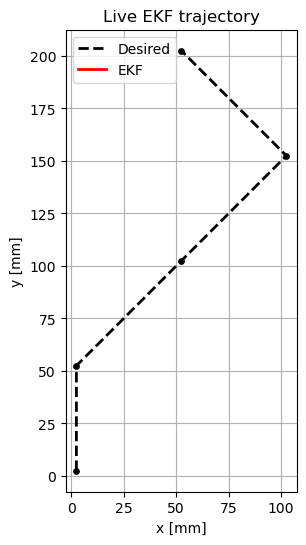

Connected: Node 30f587b4-fb96-452d-aa4f-57791877b058
i wait for variables
None
get_motor_meas 0 0
waypoints: [(2.5, 2.5), (2.5, 52.5), (102.5, 152.5), (52.5, 202.5)]
ekf: 0.0 0.0 0.0
dx, dy: 2.5 2.5
motor sets: -146.34954084936206 246.34954084936206
dist: 3.5355339059327378
get_motor_meas 0 0
waypoints: [(2.5, 52.5), (102.5, 152.5), (52.5, 202.5)]
ekf: 0.037898563812301056 -0.07823850706267015 0.00017235293164175047
dx, dy: 2.462101436187699 52.57823850706267
motor sets: -150 250
dist: 52.635853825958264
get_motor_meas -140 229
waypoints: [(2.5, 52.5), (102.5, 152.5), (52.5, 202.5)]
ekf: 1.5413515772999133 -0.08723413214478784 0.1312848793339021
dx, dy: 0.9586484227000867 52.587234132144786
motor sets: -150 250
dist: 52.59597133305325
get_motor_meas -137 229
waypoints: [(2.5, 52.5), (102.5, 152.5), (52.5, 202.5)]
ekf: 3.081506058995622 0.11119394344865399 0.2613367788598637
dx, dy: -0.5815060589956218 52.388806056551346
motor sets: -150 250
dist: 52.39203326201036
get_motor_meas -138 2

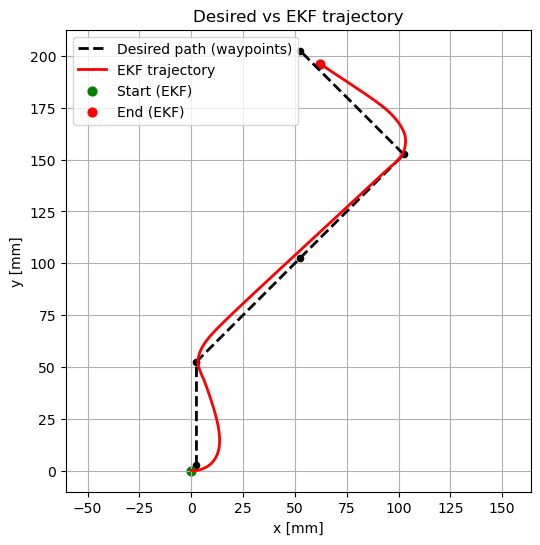

In [ ]:
# Test motion

from tdmclient import ClientAsync, aw
import math as m
import numpy as np
import asyncio
import matplotlib.pyplot as plt
from collections import deque
from matplotlib.animation import FuncAnimation

import importlib, Control_fromEKF
import Control_fromEKF
importlib.reload(Control_fromEKF)
from Control_fromEKF import follow_path, get_cmd, grid_to_mm, remove_collinear

import importlib, Filtering
import Filtering
importlib.reload(Filtering)
from Filtering import EKFState, motors_to_vw

from workingVersion.Filtering.Vision import get_robot
# params
Ts = 0.1  # time step in seconds
L = 95  # distance between wheels in mm
speed_to_mms = 0.4
375  # conversion factor from thymio speed units to mm/s from solution ex.8 (in our measurement it was 0.43478260869565216)

# Process noise for EKF (tune) (from model-mismatch/random-walk/control execution)
q_proc = (
    1e-3, 1e-2, 1e-4,   # q_x, q_y, q_theta (model mismatch)
    75.72,  0.002692,         # q_v_ctrl, q_omega_ctrl (control execution noise)
    1e-2, 1e-5          # q_v_bias, q_omega_bias (random walk on v, omega)
)
# Camera measurement noise (tune)
r_cam = (1.435, 1.864, 0.001496)  # [mm^2, mm^2, rad^2]
r_mot = (75.72, 0.002692)    # motor noise on v, omega


# 1) buffers
traj = deque(maxlen=2000)   # (x,y)
path = [(0,0), (10,0), (20, 10), (30,20), (40,10)]  # grid cells
# convert path!
waypoints = remove_collinear(grid_to_mm(path, cell_size_mm=5))
way_mm = grid_to_mm(path, cell_size_mm=5)
# EKF
ekf = EKFState(x0=[0,0,0,0,0], P0=1000*np.eye(5))
print(ekf)
ekf_traj = []
# memory for plots
def ekf_get_state():
    s = ekf.get_state()  # (x,y,theta)
    ekf_traj.append((s[0], s[1], s[2]))  # log x,y each time it's called
    return s
image = []
# 3) live figure
fig, ax = plt.subplots(figsize=(6,6))
dxs, dys = zip(*way_mm)
line_des, = ax.plot(dxs, dys, 'k--', lw=2, label='Desired')
line_traj, = ax.plot([], [], 'r-', lw=2, label='EKF')
ax.scatter(dxs, dys, c='k', s=15)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x [mm]'); ax.set_ylabel('y [mm]')
ax.grid(True); ax.legend()
ax.set_title('Live EKF trajectory')

def update(_frame):
    if len(traj) >= 2:
        xs, ys = zip(*traj)
        line_traj.set_data(xs, ys)
        # optional: keep axes autoscaled around data
        ax.relim(); ax.autoscale_view()
    return (line_traj,)

ani = FuncAnimation(fig, update, interval=150, blit=False)
plt.show(block=False)  # non-blocking window

# start connect to Thymio
client = ClientAsync()
node = aw(client.wait_for_node())
try:
    aw(node.lock()) # lock the node for R/W
except Exception:
    pass # ignore it it wasn't locked

aw(node.stop())
print("Connected:", node)
print("i wait for variables")
motors = aw(node.wait_for_variables({"motor.left.speed","motor.right.speed"}))
print(motors)

# helper functions:
def get_motor_meas(): 
    # raw speeds in Thymio units (instantaneous)
    vl = int(node.v.motor.left.speed)
    vr = int(node.v.motor.right.speed)
    print("get_motor_meas", vl, vr)
    # convert to v [mm/s], omega [rad/s] 
    v, w = motors_to_vw(vl, vr, speed_to_mms, L) 
    return np.array([v, w], dtype=float)

def get_cam_meas(image=None):
    # get position from camera
    if image is not None:
        pos, angle, __ = get_robot(image)
        return [pos, angle]
    return None


try:
    while waypoints:
        vl_cmd, vr_cmd = get_cmd()
        z_mot=get_motor_meas()
        z_cam = get_cam_meas(image)
        ekf.step(vl_cmd, vr_cmd, z_cam, r_cam=r_cam, z_mot=z_mot, r_mot=r_mot, Ts=Ts, q_proc=q_proc)
        #print("ekf results:", ekf.x, ekf.P)
        state = ekf_get_state()
        # predict
        print("waypoints:", waypoints)
        waypoints = aw(follow_path(node, state, waypoints, v_cmd=50, kp_heading=250.0,
                      pos_tol=12.0))
        
    
    x, y, th = ekf_get_state()[:3]
    print(f"Final pose (EKF): x={x:.1f} mm, y={y:.1f} mm, th={m.degrees(th):.1f} deg")
finally:
    aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))
    aw(node.unlock())
    # plots
    # Build arrays
    if len(ekf_traj) > 1:
        xs, ys, th = zip(*ekf_traj)
    else:
        xs, ys = [], []

    dxs, dys = zip(*way_mm)

    plt.figure(figsize=(6,6))
    # desired path
    plt.plot(dxs, dys, 'k--', lw=2, label='Desired path (waypoints)')
    plt.scatter(dxs, dys, c='k', s=20)

    # actual path from EKF
    plt.plot(xs, ys, 'r-', lw=2, label='EKF trajectory')
    if xs and ys:
        plt.scatter([xs[0]],[ys[0]], c='g', s=40, label='Start (EKF)')
        plt.scatter([xs[-1]],[ys[-1]], c='r', s=40, label='End (EKF)')

    plt.axis('equal')
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    plt.title('Desired vs EKF trajectory')
    plt.legend()
    plt.grid(True)
    plt.show()

In [1]:
# to stop
# Simple motion test: drive forward 1 s, then stop
from tdmclient import ClientAsync, aw

client = ClientAsync()
node = aw(client.wait_for_node())     # connect via Thymio Suite (wireless dongle)
aw(node.lock())                       # take control
aw(node.stop())                       # stop any running program on the robot
print("Connected:", node)

try:
    # (Optional) ensure speed variables are available for later use
    #aw(node.wait_for_variables({"motors.left.speed", "motors.right.speed"}))

    # Command motors: forward 150 for 1 second, then stop
    aw(node.set_variables({"motor.left.target":[150], "motor.right.target":[150]}))
    aw(client.sleep(1.0))
    aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))

finally:
    # Always release the robot
    aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))
    aw(node.unlock())

KeyboardInterrupt: 